In [2]:
import pandas as pd
import os
import numpy as np
os.chdir('/home/jovyan/shared/2020_06_10_bad_reviewer')

In [3]:
reviewer_df = pd.read_csv('results/reviewer_agg_stats.csv', index_col=[0])
cleared_submissions = pd.read_csv('bin/cleared_submissions.csv')
submissions_df = pd.read_csv('bin/submissions_df.csv', index_col=[0])
reviews_df = pd.read_csv('bin/reviews_df.csv', index_col = [0])

# Rename the columns to disambiguate whether the id represents a reviewer or an author
submissions_df = submissions_df.rename(columns={'uva_peer_assignments_user_id':'uva_peer_assignments_user_id_author'})
reviewer_df = reviewer_df.rename(columns={'uva_peer_assignments_user_id':'uva_peer_assignments_user_id_reviewer'})
reviews_df = reviews_df.rename(columns={'uva_peer_assignments_user_id':'uva_peer_assignments_user_id_reviewer'})
cleared_submissions = cleared_submissions.rename(columns={'uva_peer_assignments_user_id':'uva_peer_assignments_user_id_author'})

# Get the author id into reviews_df
reviews_df = pd.merge(reviews_df, cleared_submissions[['peer_submission_id', 'uva_peer_assignments_user_id_author']], on='peer_submission_id', how="left")
# Note that authors could only be found for 864,073 out of the 1,059,044 reviews.
reviews_df.count()

peer_review_id                                             1084657
uva_peer_assignments_user_id_reviewer                      1084657
peer_review_created_ts                                     1084657
peer_submission_id                                         1084657
peer_assignment_review_schema_part_prompt_score             929706
peer_assignment_review_schema_part_option_score             929706
peer_assignment_review_schema_part_prompt_free_response    1084640
peer_review_part_free_response_text                        1059044
uva_peer_assignments_user_id_author                         864073
dtype: int64

In [4]:
# Find duplicate essays
print(len(submissions_df))
submissions_df['is_duplicate'] = submissions_df.duplicated(subset=['text'], keep=False)
texts = submissions_df[submissions_df['is_duplicate']==False][['uva_peer_assignments_user_id_author', 'text']]

texts

27909


,uva_peer_assignments_user_id_author,text
0,0000e5af02da0c7575b3ebd346b55b29f959e90f,Reflection – visualization\n\nChallenge &...
1,0002c0f31f5c8456bd360dfcd089a64f444e2de0,Assignment :\n\n1. Challenge: Describe your ch...
2,00030b378ea62d60a177113b7854eb26cc29e1a9,VISUALIZATION\n\nChallenge I am part of the...
3,000458f7d47a0b6414f9146258829170ae3ed6a9,The main item is usually the focal point of th...
4,00069909160c6bcd9836cdb23e35b1fdaf56d0c3,Storytelling is when narratives people tell ab...
...,...,...
28342,fff43ee22d85efffada33d73f953c0d814d90290,Peter Vogt - Design Thinking Reflection - Lear...
28343,fff56a1858c62540bd76bad23db07a2fbfa963fe,STORYTELLING AS A TOOL FOR STRATEGIC CHANGES\n...
28344,fff7364558963fb9fa218f2fa08d5d2767992207,Junio 2019 Storytelling Jose Vergara\n\nChalle...
28345,fffa6add42713b8b1e2a5158616f780997bbda49,Reflexion - Mind Mapping\n\nChallenge & Select...


In [5]:
# Get number of words for the labelled texts
texts['num_words'] = texts.apply(lambda row: len(row['text'].split()), axis=1)

# Get reviewer variance
reviewer_df['total_variance'] = reviewer_df['total_sd']**2
texts

,uva_peer_assignments_user_id_author,text,num_words
0,0000e5af02da0c7575b3ebd346b55b29f959e90f,Reflection – visualization\n\nChallenge &...,583
1,0002c0f31f5c8456bd360dfcd089a64f444e2de0,Assignment :\n\n1. Challenge: Describe your ch...,1003
2,00030b378ea62d60a177113b7854eb26cc29e1a9,VISUALIZATION\n\nChallenge I am part of the...,627
3,000458f7d47a0b6414f9146258829170ae3ed6a9,The main item is usually the focal point of th...,215
4,00069909160c6bcd9836cdb23e35b1fdaf56d0c3,Storytelling is when narratives people tell ab...,1070
...,...,...,...
28342,fff43ee22d85efffada33d73f953c0d814d90290,Peter Vogt - Design Thinking Reflection - Lear...,496
28343,fff56a1858c62540bd76bad23db07a2fbfa963fe,STORYTELLING AS A TOOL FOR STRATEGIC CHANGES\n...,779
28344,fff7364558963fb9fa218f2fa08d5d2767992207,Junio 2019 Storytelling Jose Vergara\n\nChalle...,802
28345,fffa6add42713b8b1e2a5158616f780997bbda49,Reflexion - Mind Mapping\n\nChallenge & Select...,807


In [24]:
def pruneReviewers(sd_threshold):    
    good_reviewers_df = reviewer_df[(reviewer_df['total_ttr']>=sd_threshold) | (reviewer_df['total_sd'] > 0)][['uva_peer_assignments_user_id_reviewer'] ]
    good_reviewers_df['good_reviewer'] = True
    return good_reviewers_df

In [26]:
stats_dict = {'minimum_sd':[], 'num_reviews':[], 'score_correlation':[]}
for i in np.arange(0,5,0.1):
    good_reviewers = pruneReviewers(i)
    essay_scores = data_view_df.groupby(['uva_peer_assignments_user_id_reviewer', 'peer_submission_id', 'uva_peer_assignments_user_id_author']).agg({'peer_assignment_review_schema_part_option_score':'sum'}).reset_index()
    essay_scores = essay_scores.merge(good_reviewers, on='uva_peer_assignments_user_id_reviewer', how='outer')
    essay_scores = essay_scores[essay_scores['good_reviewer'] == True]
    essay_scores_final = essay_scores.groupby(['peer_submission_id', 'uva_peer_assignments_user_id_author']).agg({'peer_assignment_review_schema_part_option_score':'mean'}).reset_index()
    correlation_df = essay_scores_final.merge(texts_df[['uva_peer_assignments_user_id_author', 'num_words']], on='uva_peer_assignments_user_id_author')
    stats_dict['minimum_sd'].append(i)
    stats_dict['num_reviews'].append(len(essay_scores[essay_scores['good_reviewer']==True]))
    stats_dict['score_correlation'].append(correlation_df[['peer_assignment_review_schema_part_option_score','num_words']].corr().iloc[0,1])

In [28]:
stats_dict

{'minimum_sd': [0.0,
  0.1,
  0.2,
  0.30000000000000004,
  0.4,
  0.5,
  0.6000000000000001,
  0.7000000000000001,
  0.8,
  0.9,
  1.0,
  1.1,
  1.2000000000000002,
  1.3,
  1.4000000000000001,
  1.5,
  1.6,
  1.7000000000000002,
  1.8,
  1.9000000000000001,
  2.0,
  2.1,
  2.2,
  2.3000000000000003,
  2.4000000000000004,
  2.5,
  2.6,
  2.7,
  2.8000000000000003,
  2.9000000000000004,
  3.0,
  3.1,
  3.2,
  3.3000000000000003,
  3.4000000000000004,
  3.5,
  3.6,
  3.7,
  3.8000000000000003,
  3.9000000000000004,
  4.0,
  4.1000000000000005,
  4.2,
  4.3,
  4.4,
  4.5,
  4.6000000000000005,
  4.7,
  4.800000000000001,
  4.9],
 'num_reviews': [152725,
  127572,
  119805,
  115570,
  112648,
  110120,
  107899,
  107006,
  106603,
  106322,
  106133,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,
  105674,


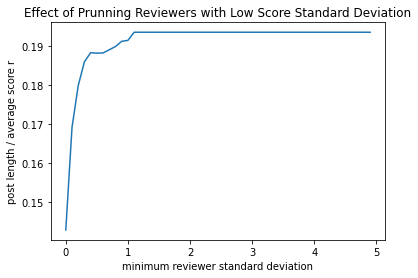

In [27]:
import matplotlib.pyplot as plt
plt.plot(stats_dict['minimum_sd'], stats_dict['score_correlation'])
plt.xlabel('minimum reviewer standard deviation')
plt.ylabel('post length / average score r')
plt.title('Effect of Prunning Reviewers with Low Score Standard Deviation')
plt.show()

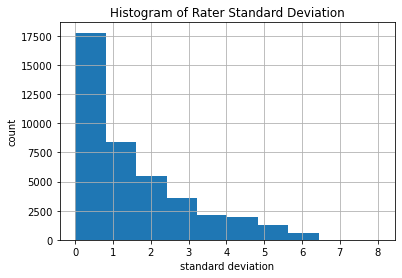

In [9]:
reviewer_df['total_sd'].hist()
plt.ylabel('count')
plt.xlabel('standard deviation')
plt.title('Histogram of Rater Standard Deviation')
plt.show()

In [10]:
bad_reviewer_dict = {'minimum_sd': [], 'excluded_essays':[]}
def pruneReviewersNum(sd_threshold):
    good_reviewers_df = reviewer_df[reviewer_df['total_sd']>=sd_threshold][['uva_peer_assignments_user_id_reviewer']]
    good_reviewers_df['good_reviewer'] = 1
    return good_reviewers_df

for i in np.arange(0,5,0.1):
    good_reviewers = pruneReviewersNum(i)
    essay_scores = data_view_df.groupby(['uva_peer_assignments_user_id_reviewer', 'peer_submission_id', 'uva_peer_assignments_user_id_author']).agg({'peer_assignment_review_schema_part_option_score':'sum'}).reset_index()
    essay_scores = essay_scores.merge(good_reviewers, on='uva_peer_assignments_user_id_reviewer', how='outer')
    essay_scores['good_reviewer'].fillna(0)
    good_reviewers_df = essay_scores.groupby('peer_submission_id').agg({'good_reviewer':'sum'}).reset_index()
    bad_reviewer_dict['excluded_essays'].append(len(good_reviewers_df[good_reviewers_df['good_reviewer'] <= 1]))
    bad_reviewer_dict['minimum_sd'].append(i)

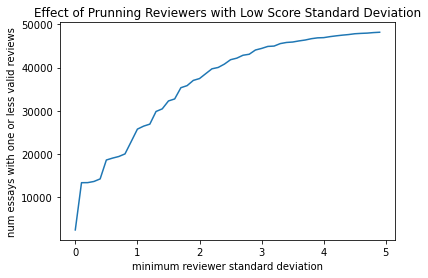

In [11]:
import matplotlib.pyplot as plt
plt.plot(bad_reviewer_dict['minimum_sd'], bad_reviewer_dict['excluded_essays'])
plt.xlabel('minimum reviewer standard deviation')
plt.ylabel('num essays with one or less valid reviews')
plt.title('Effect of Prunning Reviewers with Low Score Standard Deviation')
plt.show()